In [4]:
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
import sklearn
import ast
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# %matplotlib qt

In [5]:
df_movie = pd.read_csv("data/Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

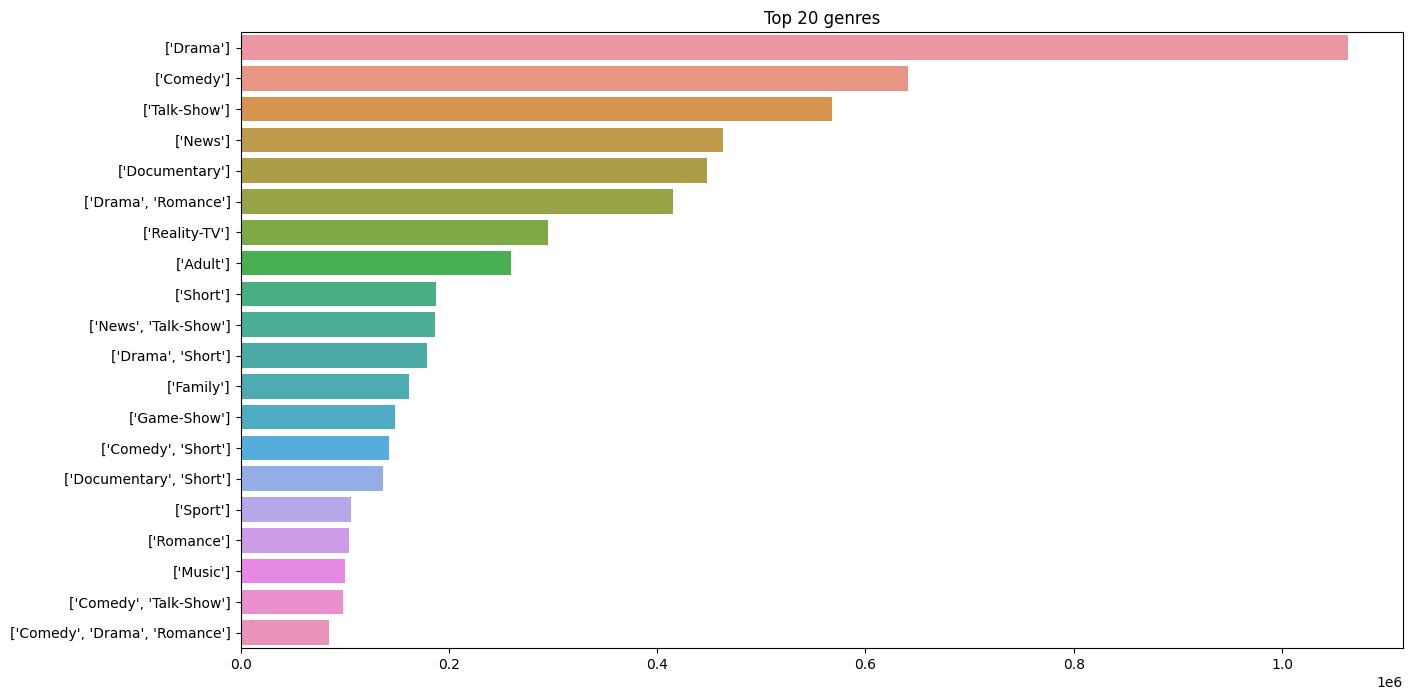

In [6]:
df_genre = df_movie.copy()
df_genre.dropna(subset=['Movie genres names'], inplace=True)
count_genre = df_genre['Movie genres names'].value_counts()
plt.figure(figsize=(15,8))
ax = sns.barplot(x=count_genre.values[0:20], y=count_genre.index[0:20]).set(title='Top 20 genres')
plt.show()

### Create dummies for genres

In [7]:
data = df_movie[['Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()

In [8]:
# incorporate dummies into data for genres
# recreate genre lists from string format
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          2604
Comedy         1876
Action         1398
Crime          1021
Romance         905
Adventure       882
Thriller        870
Horror          593
Mystery         486
Fantasy         442
Sci-Fi          432
Biography       314
Family          250
History         177
Music           167
Sport           120
War             106
Musical          60
Animation        51
Western          45
Documentary      39
Adult             2
News              2
dtype: int64

In [9]:
def incorporate_genre_dummies(data):
    # transform into dummies
    movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
    df = pd.get_dummies(pd.DataFrame(movie_genres))
    df.columns = df.columns.str.split("_").str[-1]

    # need to sum similarly named columns due to unwanted effect of previous computation
    df = df.groupby(level=0, axis=1).sum()
    genre_names = df.columns

    # adding to data and removing old genre column
    data[df.columns] = df.values
    data = data.drop('Movie genres names', axis = 1)

    # rename problematic Sci-Fi column name
    data.rename(columns={'Sci-Fi' : 'SciFi'}, inplace = True)
    genre_names = [x if x != 'Sci-Fi' else 'SciFi' for x in genre_names]

    return data, genre_names

In [10]:
data, genre_names = incorporate_genre_dummies(data)

In [11]:
data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)

In [12]:
data['log_revenue'] = np.log(data['corr_revenue'])

In [13]:
data.head(2)

,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Musical,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue
33,7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,15.361558
231,7.0,7.431127e+07,2.694641e+08,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,19.411946


# Genre distribution
#### distribution of the rating across genre


In [103]:
def bootstrap(data, n_it):
    means = np.zeros(n_it)
    data = np.array(data)
    
    for n in range(n_it):
        indices = np.random.randint(0, len(data), len(data))
        data_new = data[indices] 
        means[n] = np.nanmean(data_new)
    
    # 95% CI -> 2.5% and 97.5%
    return [np.nanmean(means), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

def plot_CIs(CIs, params):
    # function to plot confidence intervals
    # adapted code from solutions of tutorial 4

    # Compute interval center and half interval length for plotting
    means = np.array([CI[0] for CI in CIs])
    one_sided_CI = np.array([(CI[2] - CI[1]) / 2 for CI in CIs])

    # plot CIs
    plt.figure(figsize=(8,5))
    plt.errorbar(means, np.array(range(len(means))), xerr=one_sided_CI, linewidth=1,
                 linestyle='none', marker='o', markersize=3,
                 markerfacecolor='black', markeredgecolor='black', capsize=5)
    plt.vlines(0, 0, len(means), linestyle='--')
    plt.yticks(range(len(params)), params);
    plt.title('95% confidence intervals')
    plt.show()
    
def difference_in_usage(data_, g, CI_list, measure) :
    #difference returns -1 (absent for winner and present for the loser), 0 (present or absent in both), or 1 (present for the winner and absent for looser). 
    d = data_[data_[g]==1][measure]
    b = bootstrap(d, 1000)
    CI_list.append(b)

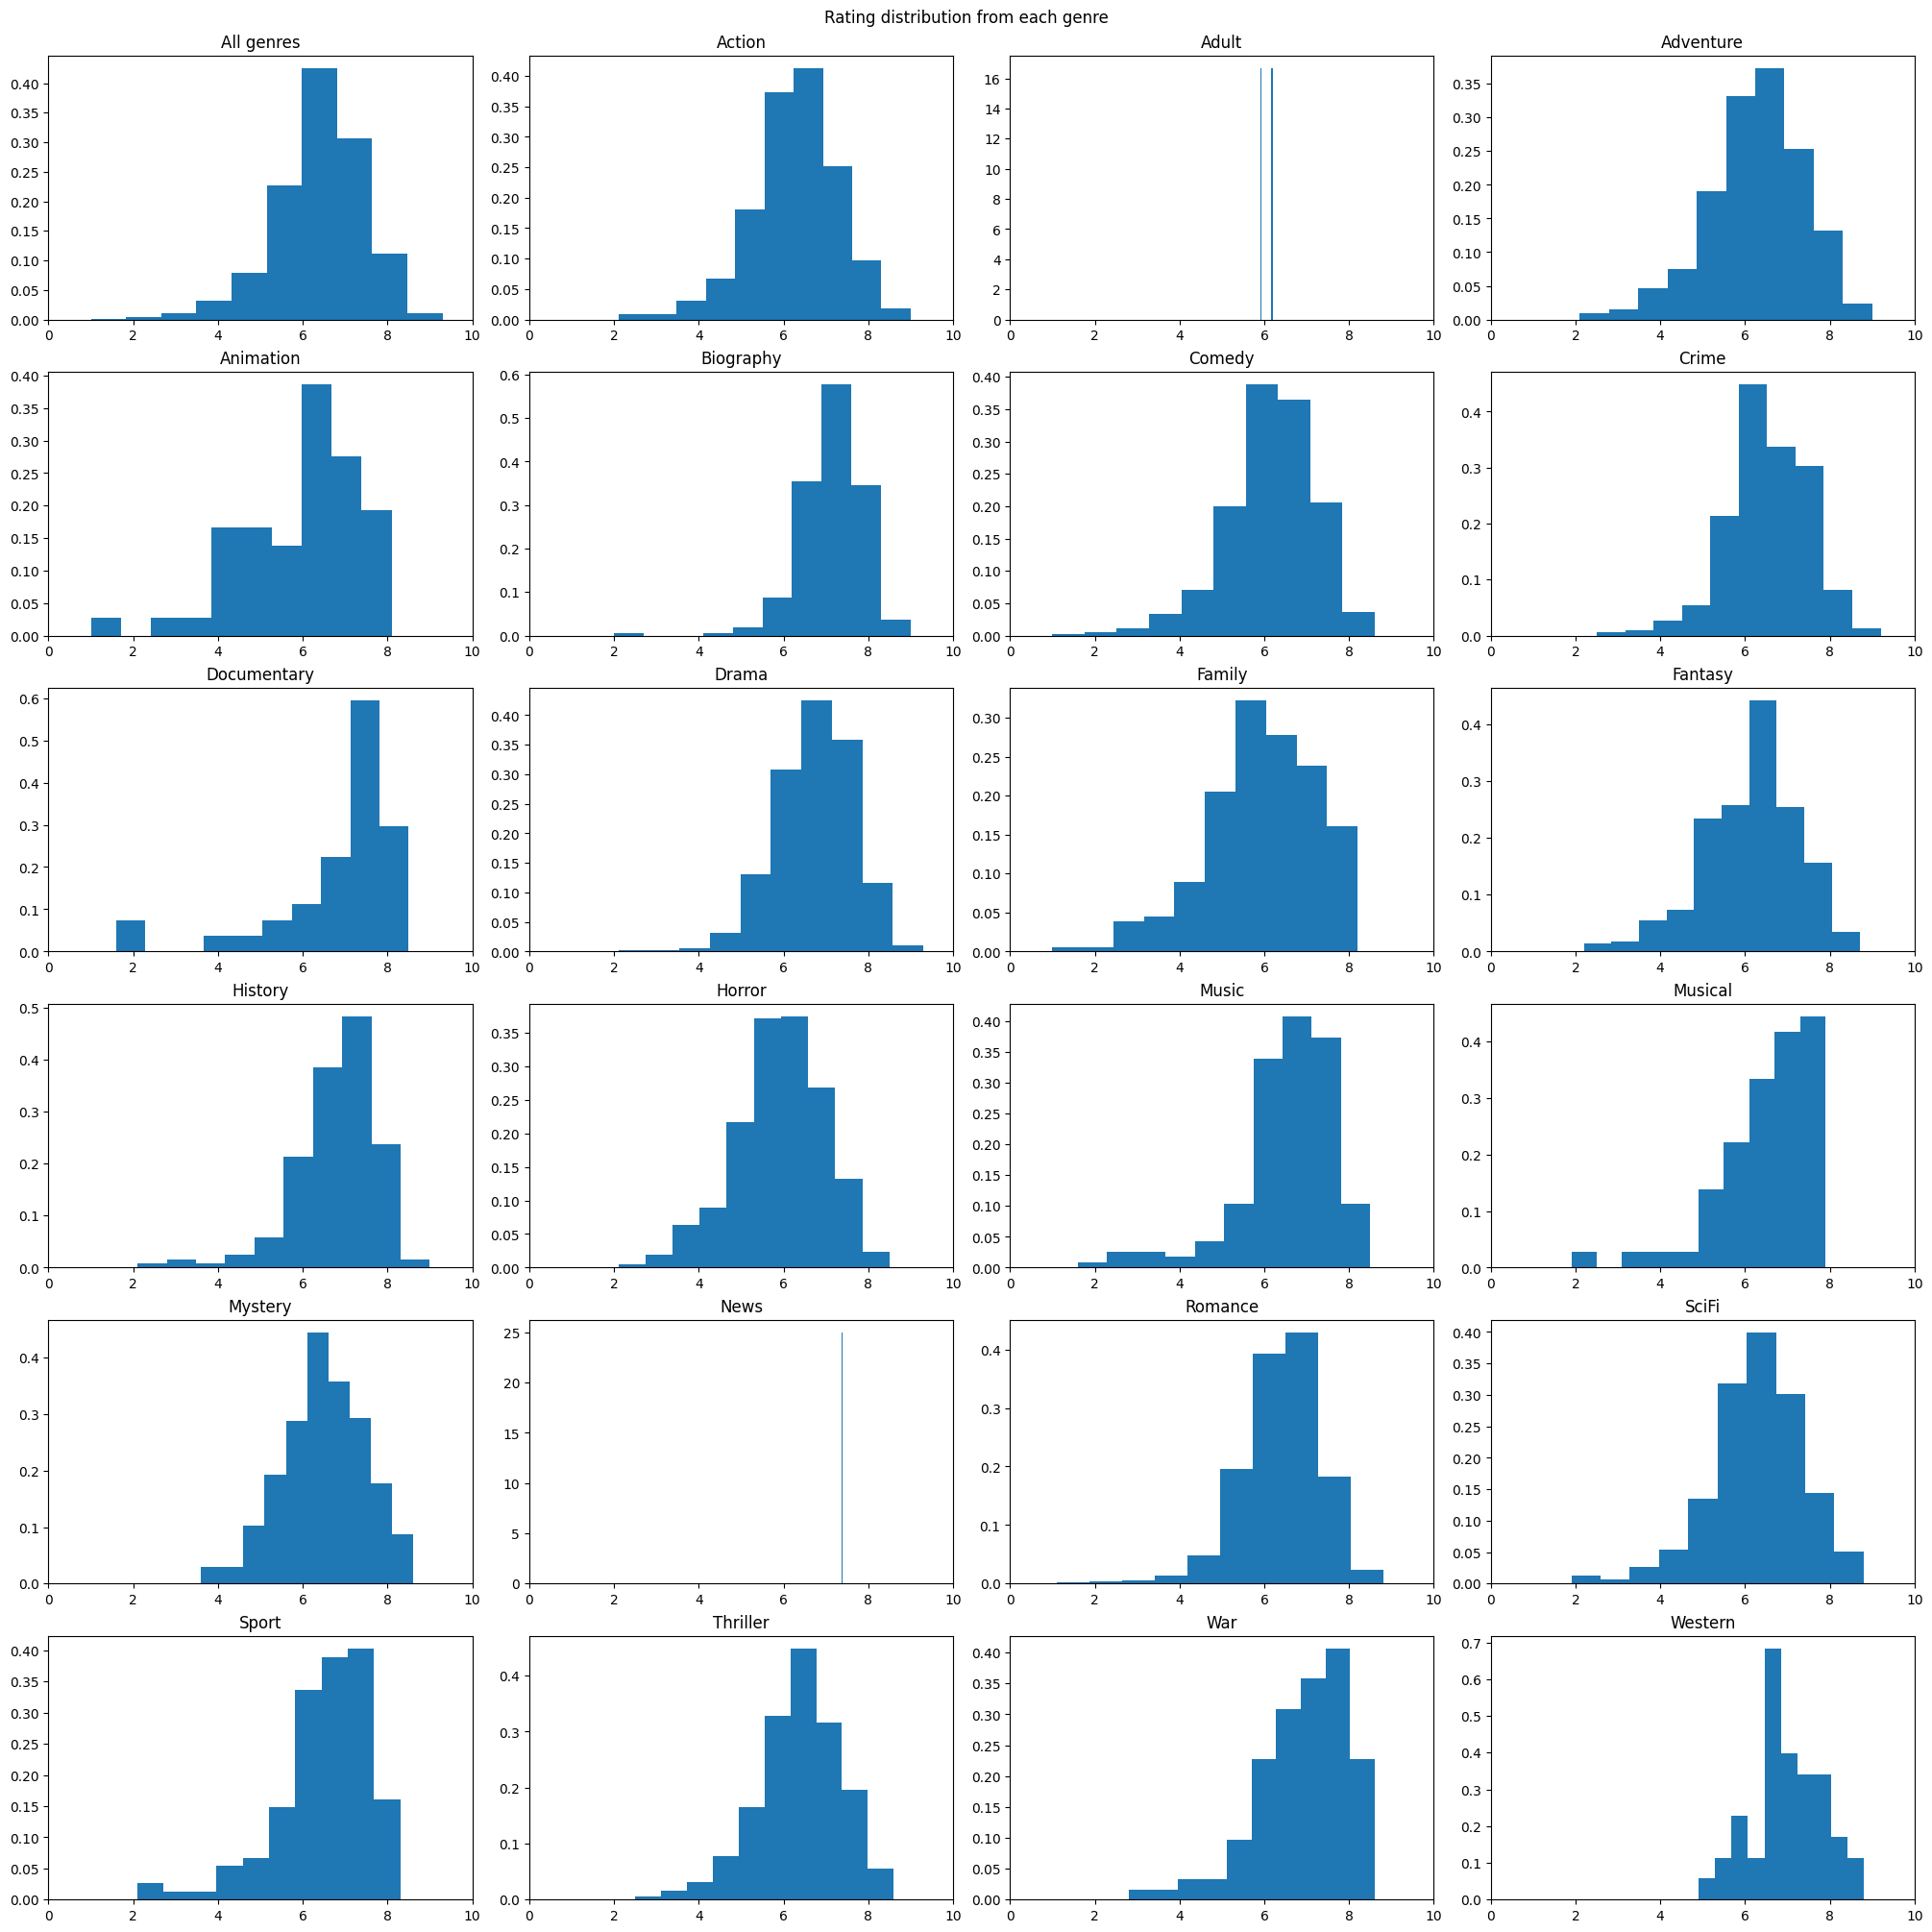

In [72]:
fig, axs = plt.subplots(6,4, constrained_layout=True, figsize=(20, 20))
fig.suptitle('Rating distribution from each genre')

axs[0,0].hist(data.averageRating, density=True)
axs[0,0].set_title('All genres')
axs[0,0].set_xlim(0,10)
for i, g in enumerate(genre_names):
    i = i+1
    ax = axs[int(i/4),i%4]
    ax.hist(data[data[g]==1].averageRating, density=True)
    ax.set_title(g)
    ax.set_xlim(0,10)


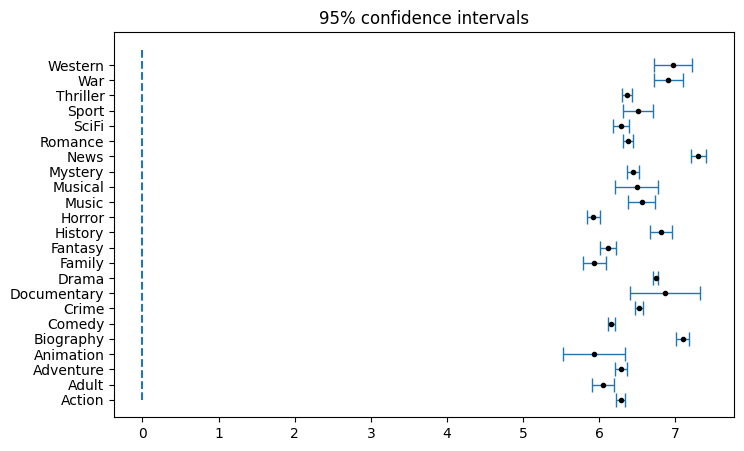

In [104]:
CIs = []    
    
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='averageRating')
    
plot_CIs(CIs, genre_names)

#### distribution of the budget across genre


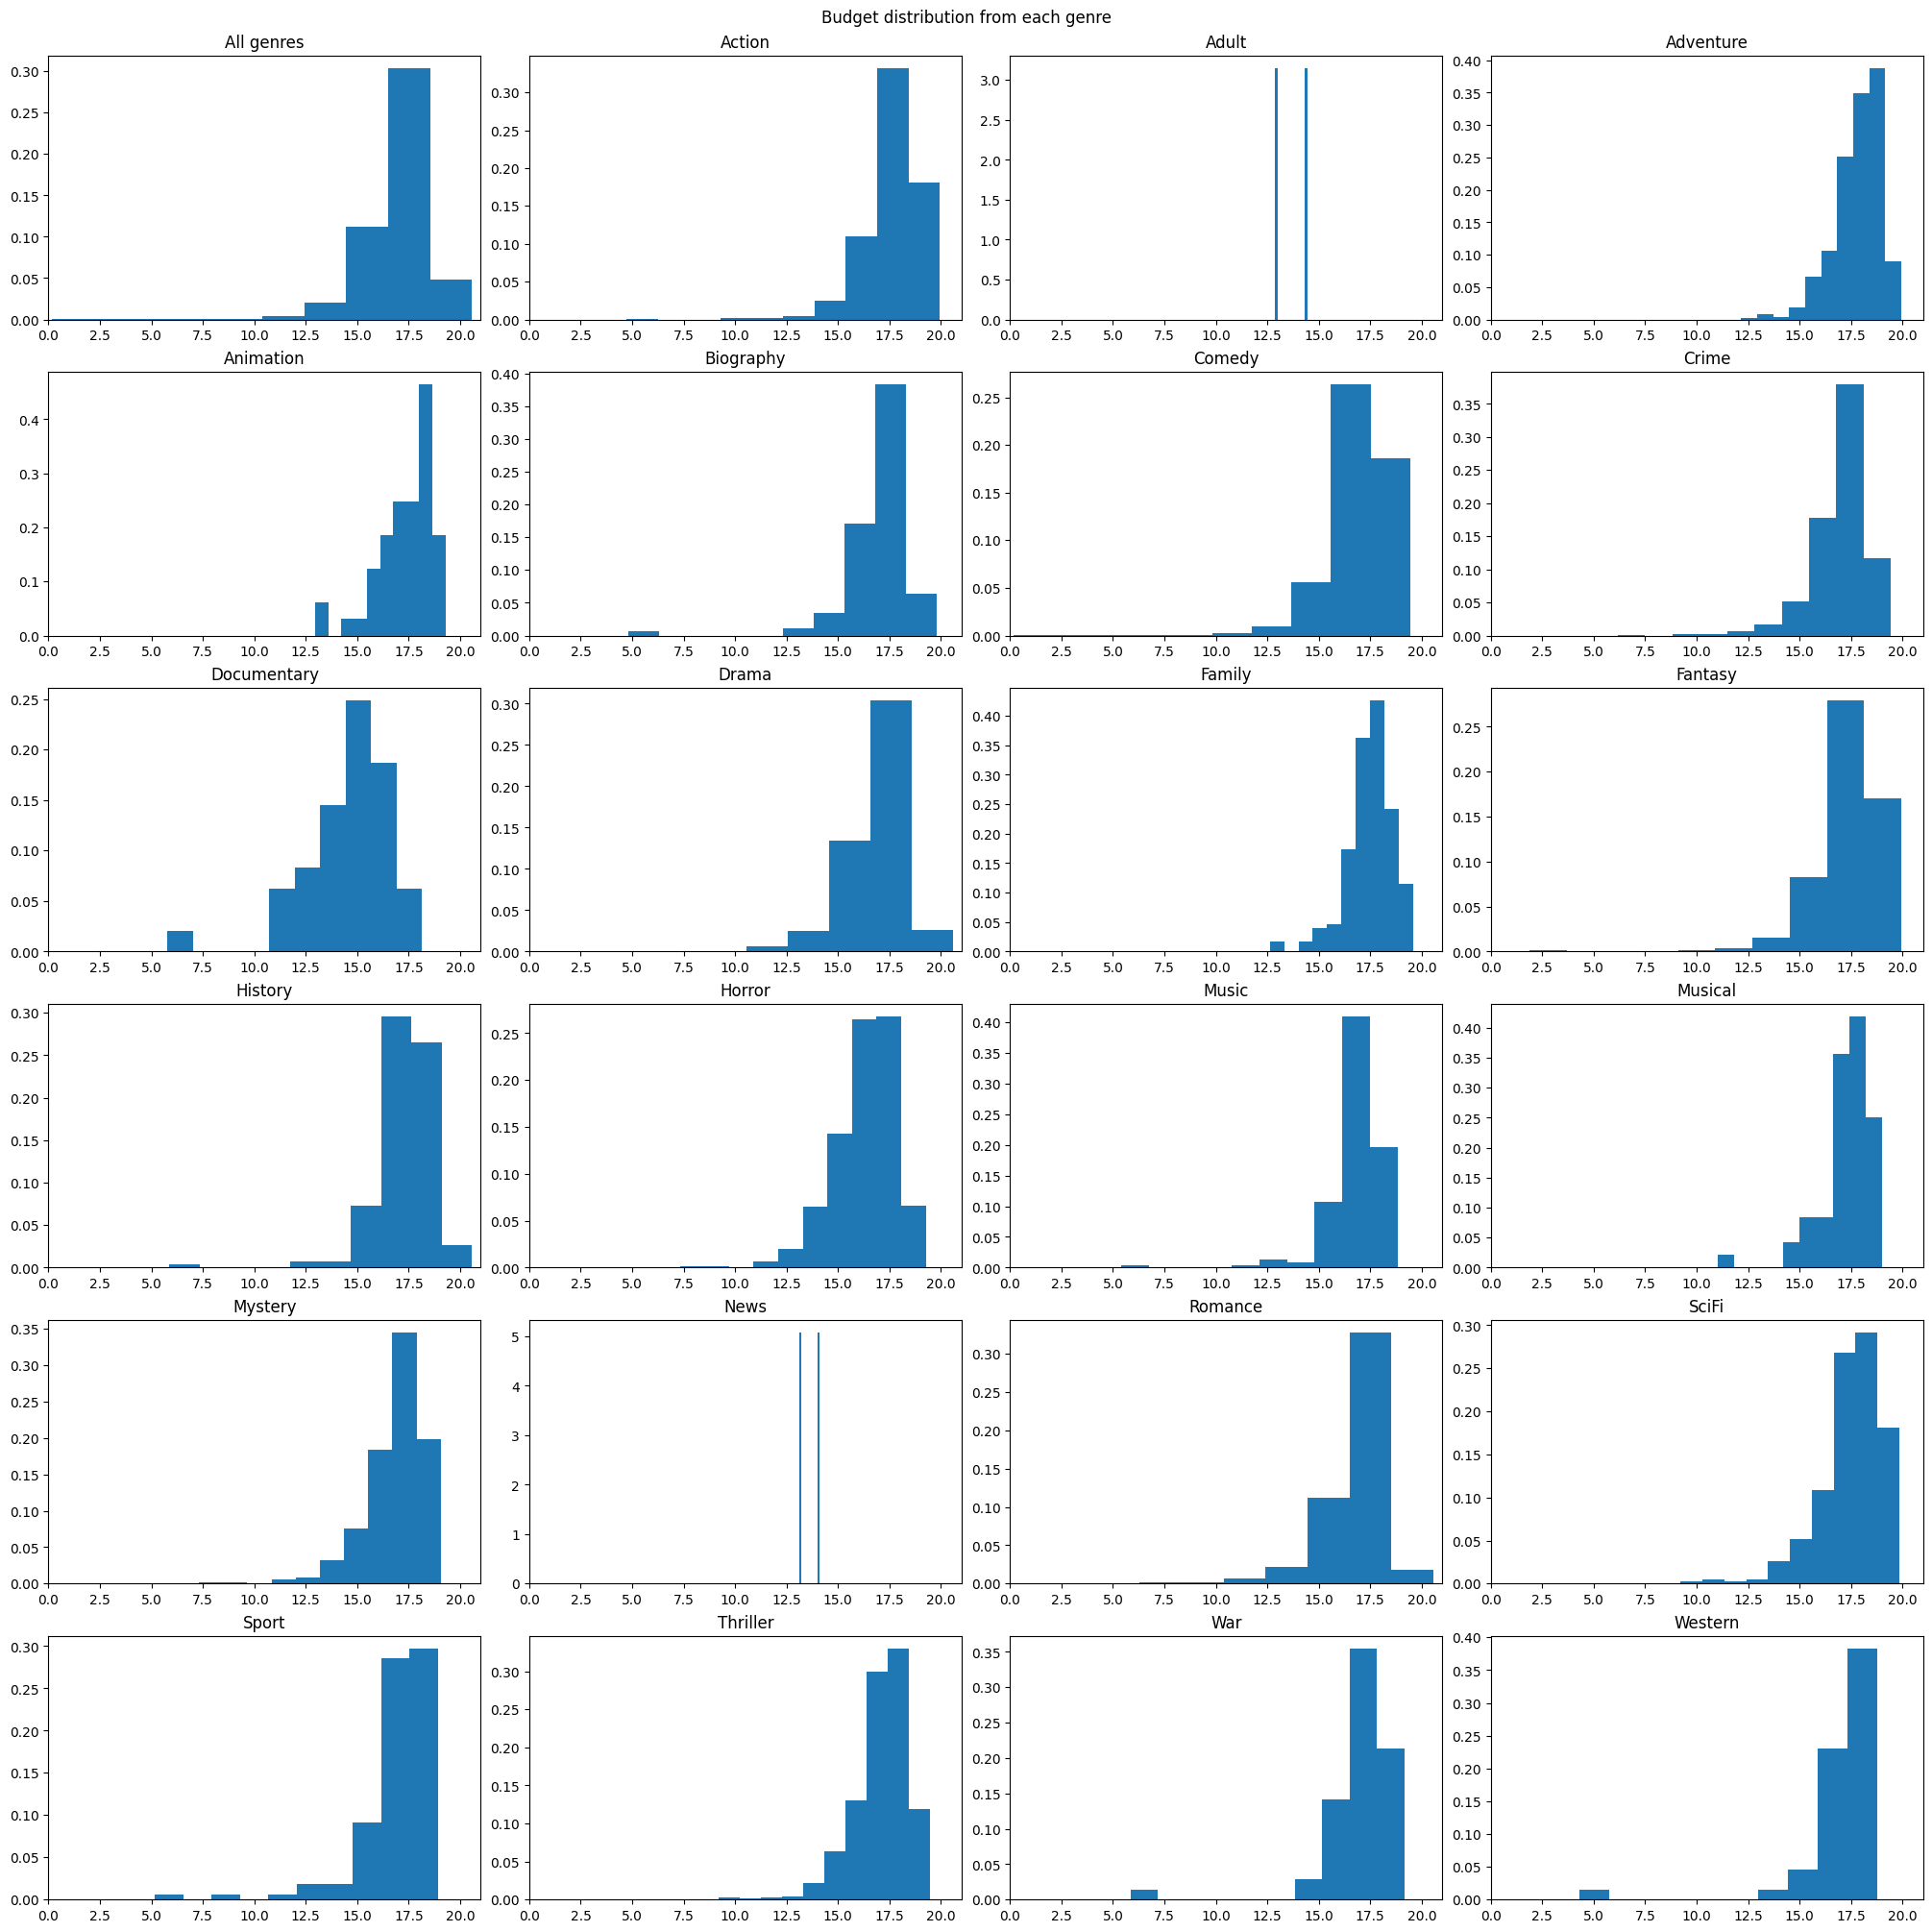

In [79]:
# create a log distribution for budget
data['log_budget'] = np.log(data['corr_budget'])

fig, axs = plt.subplots(6,4, constrained_layout=True, figsize=(20, 20))
fig.suptitle('Budget distribution from each genre')

axs[0,0].hist(data.log_budget, density=True)
axs[0,0].set_title('All genres')
axs[0,0].set_xlim(0,21)
for i, g in enumerate(genre_names):
    i = i+1
    ax = axs[int(i/4),i%4]
    ax.hist(data[data[g]==1].log_budget, density=True)
    ax.set_title(g)
    ax.set_xlim(0,21)

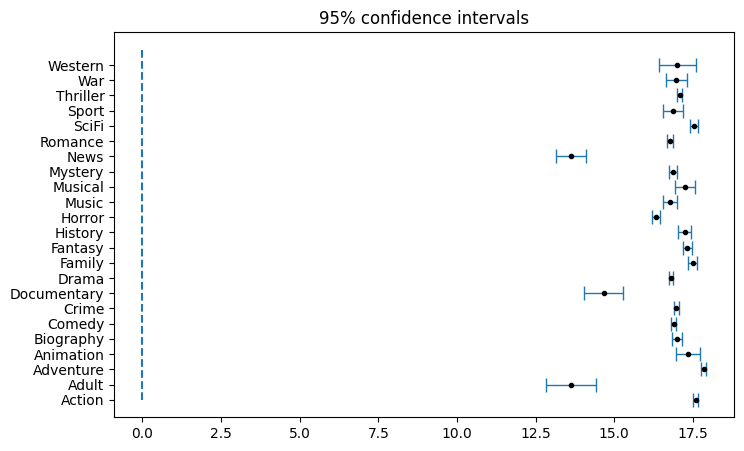

In [105]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_budget')
    
plot_CIs(CIs, genre_names)

#### distribution of the revenue across genre


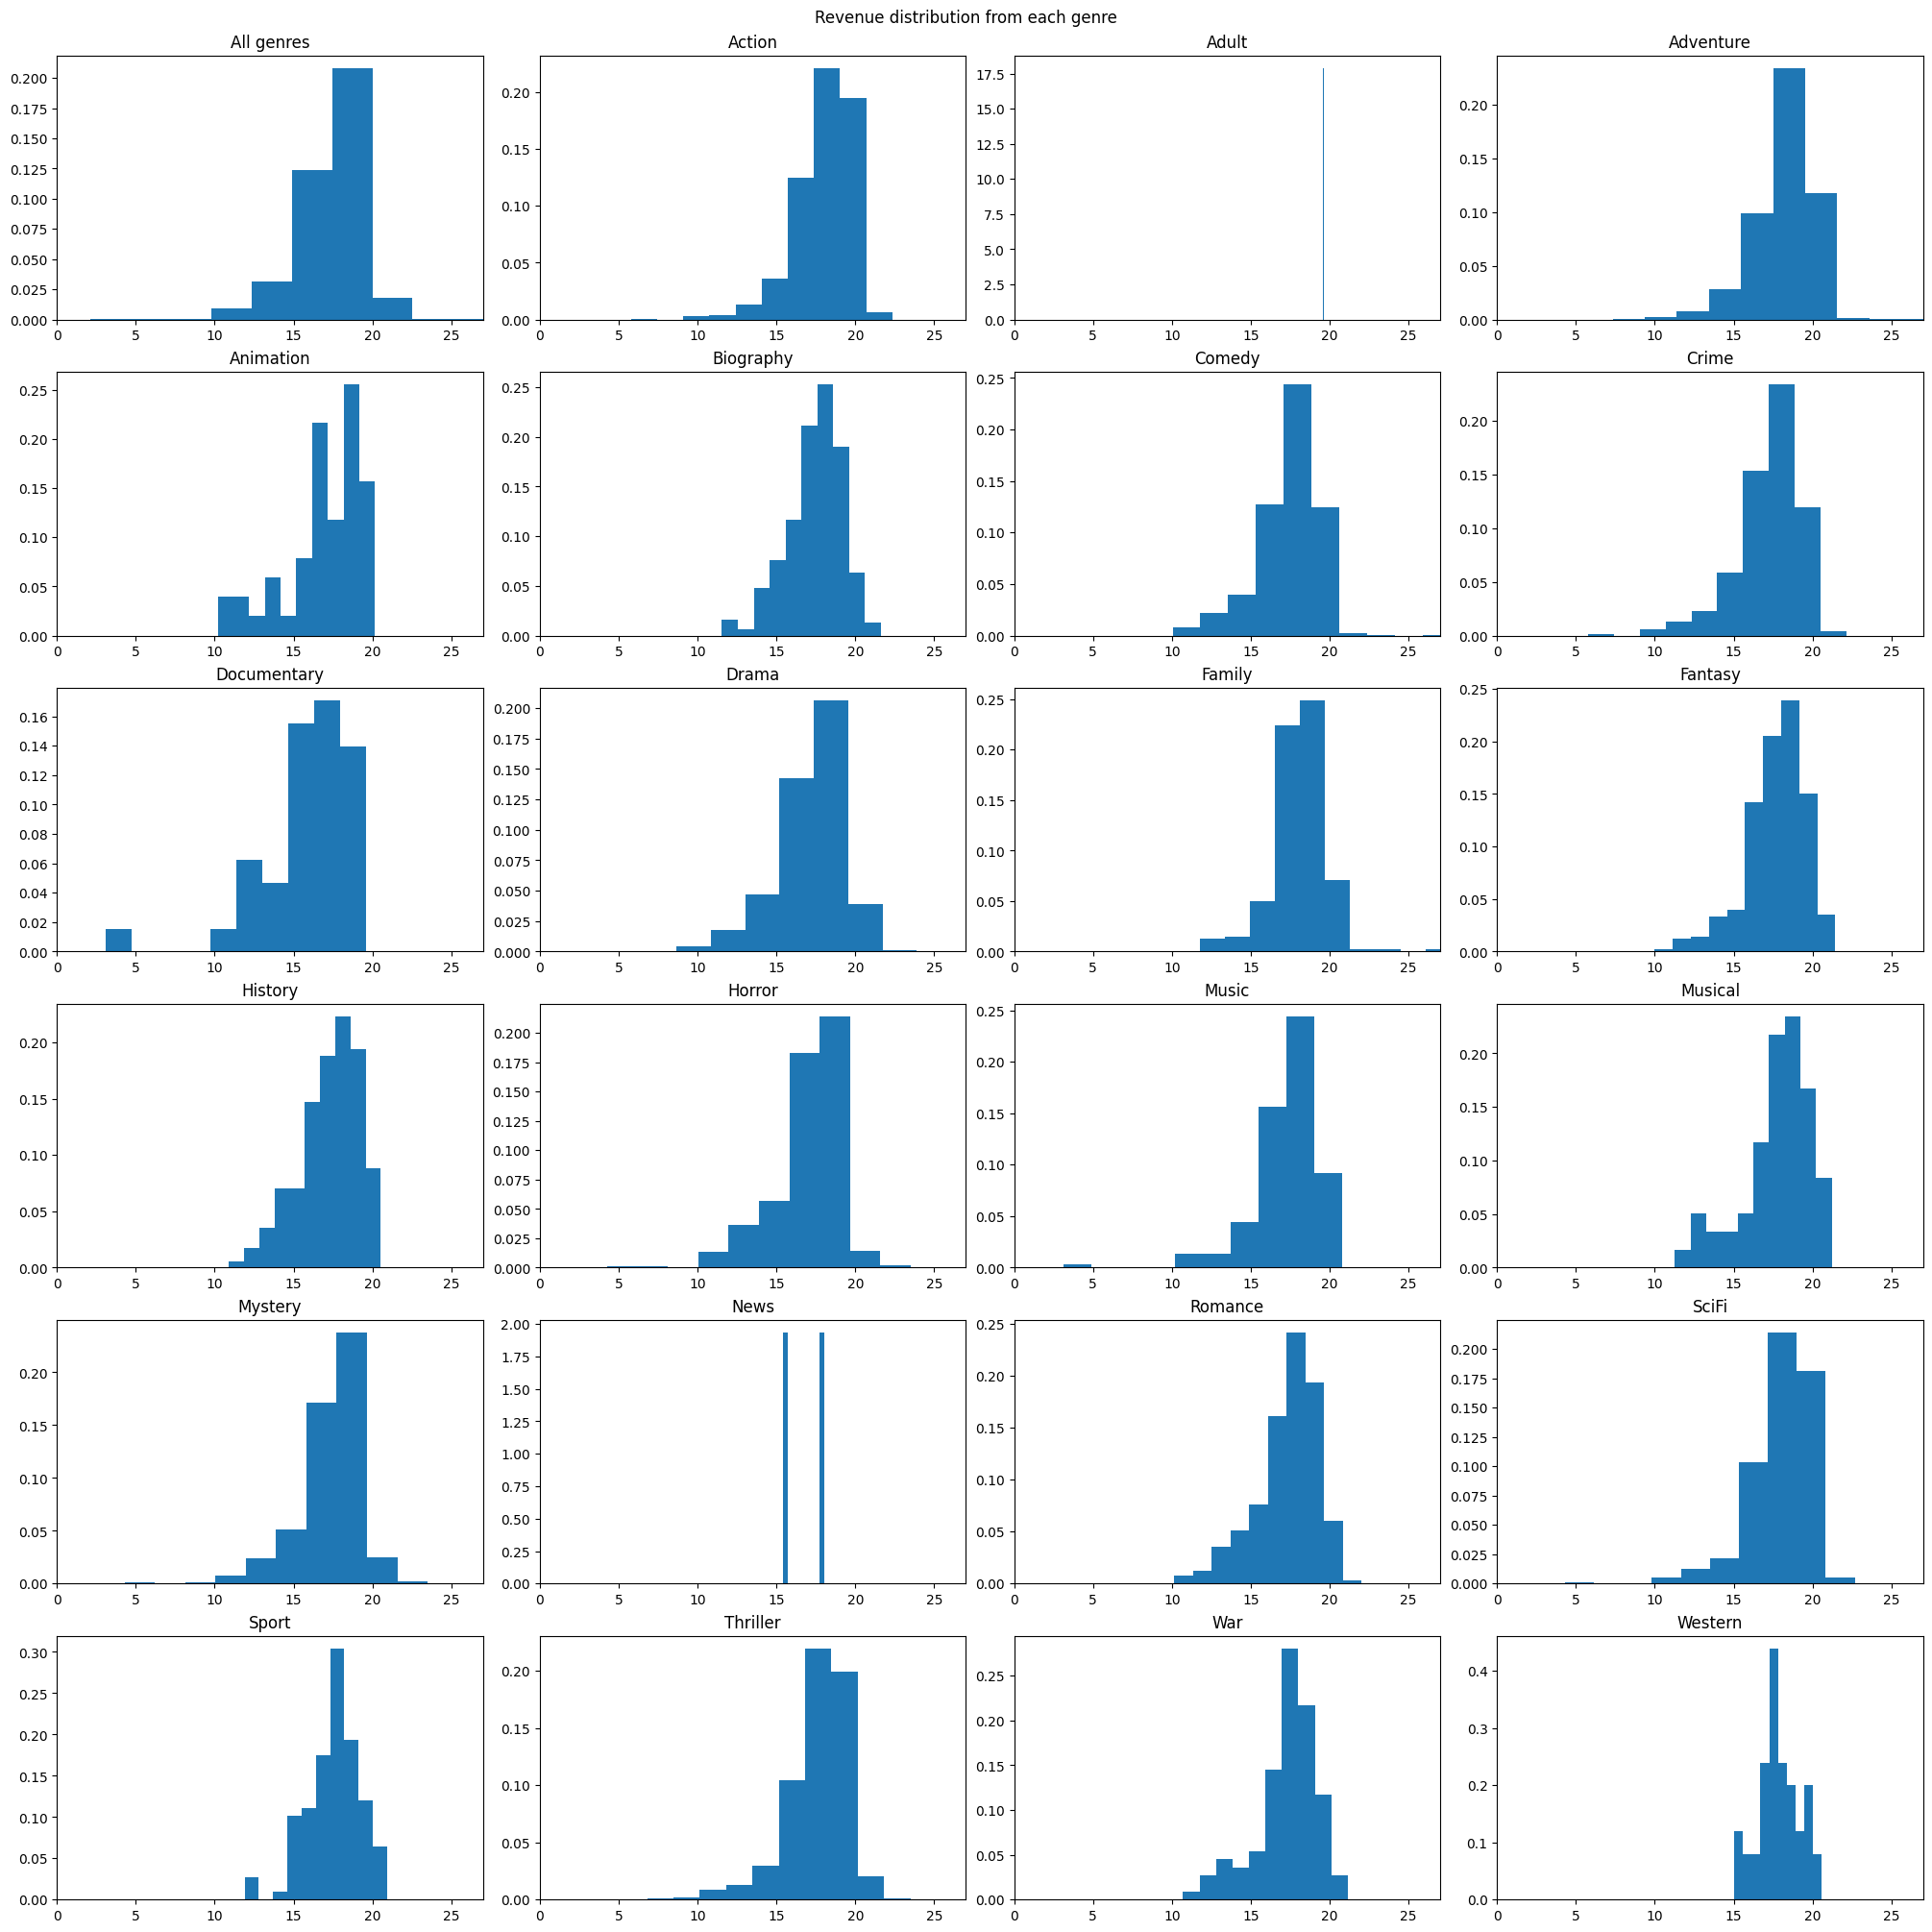

In [84]:
fig, axs = plt.subplots(6,4, constrained_layout=True, figsize=(20, 20))
fig.suptitle('Revenue distribution from each genre')

axs[0,0].hist(data.log_revenue, density=True)
axs[0,0].set_title('All genres')
axs[0,0].set_xlim(0,27)
for i, g in enumerate(genre_names):
    i = i+1
    ax = axs[int(i/4),i%4]
    ax.hist(data[data[g]==1].log_revenue, density=True)
    ax.set_title(g)
    ax.set_xlim(0,27)

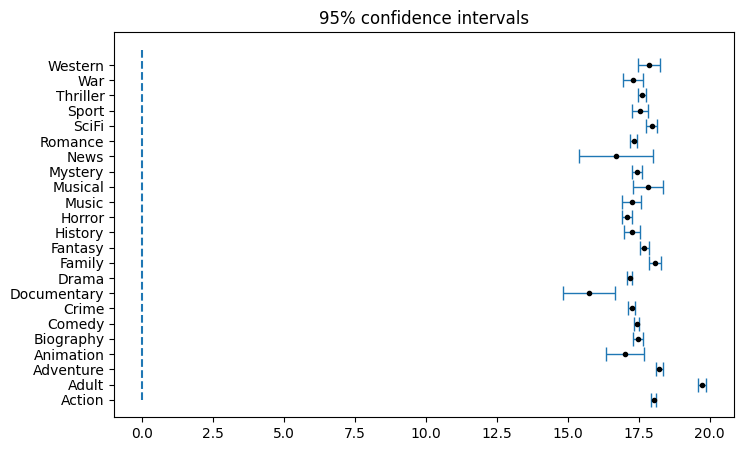

In [106]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_revenue')
    
plot_CIs(CIs, genre_names)

### Linear regression: average ratings, revenue

In [221]:
def barplot(res, figsize=(5,7)) :
    ''' Barplot of the coefficients of the linear regression sorted by value'''
    tmp = []
    for name, value in zip(res.params.index, res.params):
        tmp.append({"name": name, "value": value})

    features_coef = pd.DataFrame(tmp).sort_values("value")

    plt.subplots(figsize=figsize)
    plt.barh(features_coef.name, features_coef.value, alpha=0.6)
    plt.show()


In [222]:
mod = smf.ols(formula="averageRating ~ Action + Adult + Adventure +\
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Musical + Mystery +\
       News + Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     40.92
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          9.61e-168
Time:                        16:10:31   Log-Likelihood:                -6949.0
No. Observations:                5024   AIC:                         1.395e+04
Df Residuals:                    5000   BIC:                         1.410e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.4015      0.061    105.454      

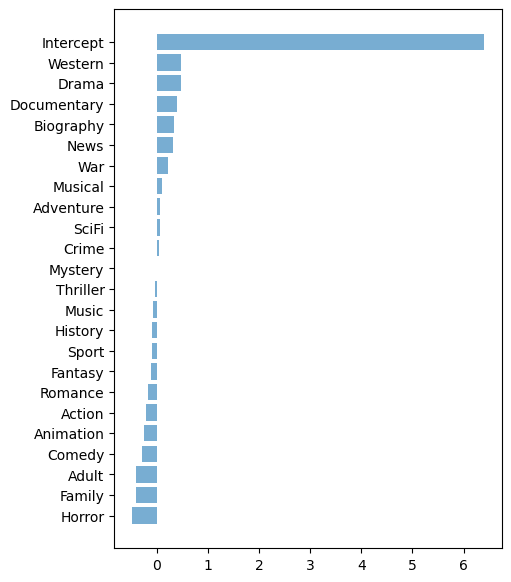

In [223]:
barplot(res)

**Biography, Documentary, Drama, Western** are significantly driving the grades upwards, while **Action, Comedy, Family, Horror and Romance** drive it downwards.

In [224]:
mod = smf.ols(formula="log_revenue ~ Action + Adult + Adventure + \
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Musical + Mystery +\
       News + Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     19.29
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           8.11e-76
Time:                        16:10:31   Log-Likelihood:                -10458.
No. Observations:                5024   AIC:                         2.096e+04
Df Residuals:                    5000   BIC:                         2.112e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.0097      0.122    139.371      

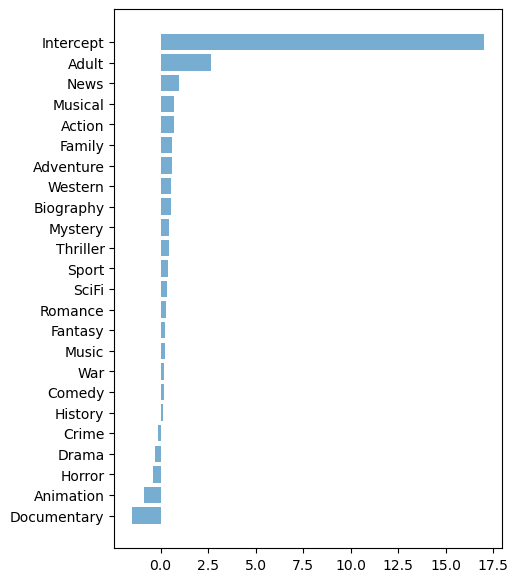

In [225]:
barplot(res)

**Action, Adventure, Biography, Family, Mystery, Thriller** are significantly driving the revenue upwards, while **Animation, Documentary, Drama and Horror** drive it downwards.

Some genres have a similar effect on grades and revenue, like **Biography (upward) and Horror (downward)**. While **Action** movies are generally associated to a bad movie, it paradoxically generates a lot of revenue. On the contrary, while **Documentaries** are well graded, they produce little revenue.

In [226]:
mod = smf.ols(formula="log_revenue ~ Comedy*Romance + \
                                    Comedy*Drama + \
                                    Drama*Romance ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     21.39
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           6.07e-25
Time:                        16:10:31   Log-Likelihood:                -10608.
No. Observations:                5024   AIC:                         2.123e+04
Df Residuals:                    5017   BIC:                         2.128e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.9072      0.058    308.

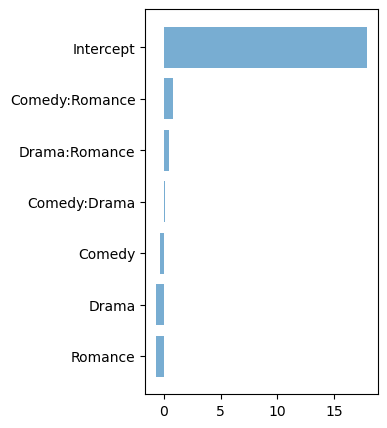

In [227]:
barplot(res, figsize=(3,5))

Interestingly, for very common genre associations, we observe that their combination has a positive effect on revenue, while the genre alone tend to provoke a decrease.

In [228]:
mod = smf.ols(formula="averageRating ~ Comedy*Romance + \
                                    Comedy*Drama + \
                                    Drama*Romance ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     112.9
Date:                Thu, 01 Dec 2022   Prob (F-statistic):          4.50e-134
Time:                        16:10:31   Log-Likelihood:                -7064.0
No. Observations:                5024   AIC:                         1.414e+04
Df Residuals:                    5017   BIC:                         1.419e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.1479      0.029    214.

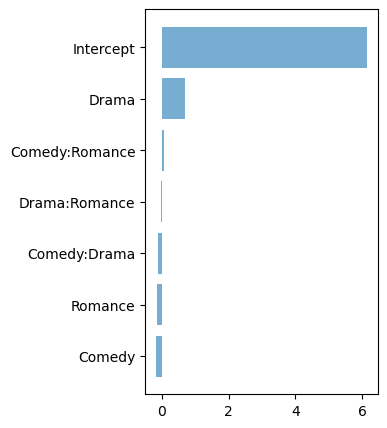

In [229]:
barplot(res, figsize=(3,5))

No such effect can be seen (with any significance) on the average IMDB rating, which implies that revenue is driving the market.

### Boxplots

In [73]:
# create a log distribution for budget
data['log_budget'] = np.log(data['corr_budget'])

In [231]:
budget, revenue, rating = list(), list(), list()
for genre in genre_names:
    budget.append(data[data[genre] == 1]['log_budget'])
    revenue.append(data[data[genre] == 1]['log_revenue'])
    rating.append(data[data[genre] == 1]['averageRating'])

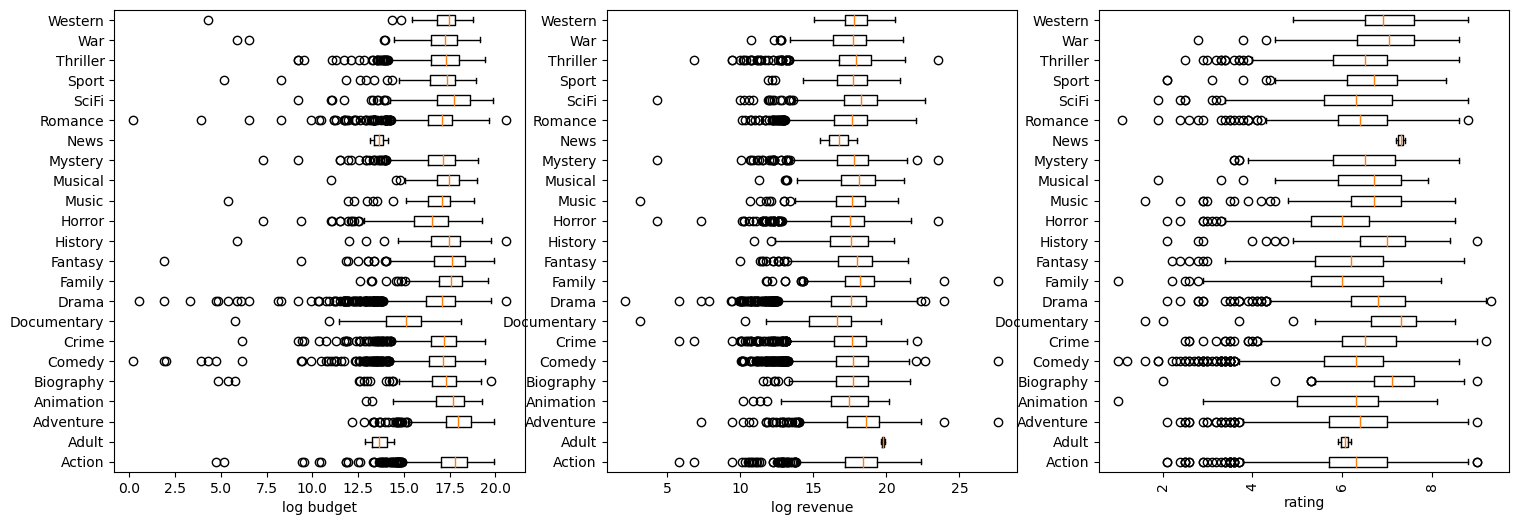

In [232]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6))
axs[0].boxplot(budget, labels=genre_names, vert = False)
axs[0].set_xlabel('log budget')
axs[1].boxplot(revenue, labels=genre_names, vert = False)
axs[1].set_xlabel('log revenue')
axs[2].boxplot(rating, labels=genre_names, vert = False)
axs[2].set_xlabel('rating')
plt.xticks(rotation=90)
plt.show()

Useful ?

### Clustering pipeline (and dimensionality reduction)
As revenue and budget are heavy-tailed, we take their log (done previously), which transforms it into a gaussian-like distribution, which we can then standardize. Average ratings are already gaussian-like; we also standardize them.

In [233]:
def standardize(data):
    return (data - np.nanmean(data)) / np.std(data)

def normalize(data):
    return (data-data.min()) / (data.max() - data.min())

In [234]:
# create standardize distribution of (log) distributions
data['log_budget'] = standardize(data['log_budget'])
data['log_revenue'] = standardize(data['log_revenue'])
data['averageRating'] = standardize(data['averageRating'])

#data['log_budget'] = normalize(data['log_budget'])
#data['log_revenue'] = normalize(data['log_revenue'])
#data['averageRating'] = normalize(data['averageRating'])

# remove unwanted column for clustering
data.drop(['corr_budget', 'corr_revenue'], axis = 1, inplace=True)

Now we can perform dimensionality reduction

In [235]:
pca = decomposition.PCA(n_components=10)
pca.fit(data.T)

PCA(n_components=10)

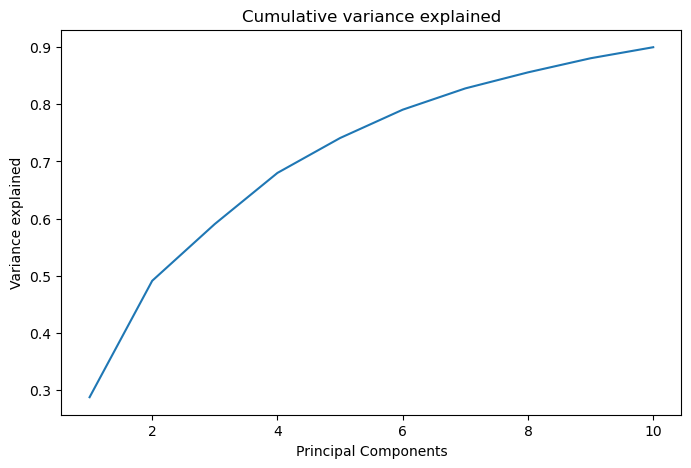

In [236]:
# compute cumulative explained variance
plt.figure(figsize=(8,5))
plt.title('Cumulative variance explained')
sns.lineplot(x = np.arange(1,11,1), y = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance explained')
plt.show()

With 10 components, we can capture 90% of the variance in the data, but we already capture 80% with 6 components.
Let's observe some 2D principal components plots.

In [237]:
def plot_components(comp, color = None, alpha = None):
    if color is None : color = 'darkgreen'
    fig, axs = plt.subplots(ncols=3, figsize=(10,5), layout="constrained")
    axs[0].scatter(comp[0,:], comp[1,:], c = color, alpha = alpha)
    axs[0].set_xlabel('PC1')
    axs[0].set_ylabel('PC2')
    axs[1].scatter(comp[0,:], comp[2,:], c = color, alpha = alpha)
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC3')
    axs[2].scatter(comp[1,:], comp[2,:], c = color, alpha = alpha)
    axs[2].set_xlabel('PC2')
    axs[2].set_ylabel('PC3')
    plt.suptitle('Principal components subplots')
    plt.show()

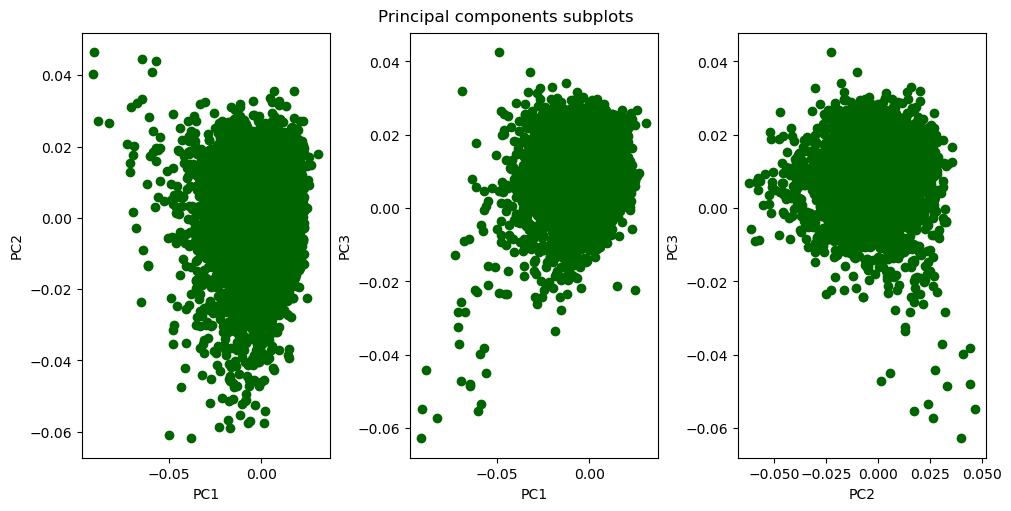

In [238]:
plot_components(pca.components_)

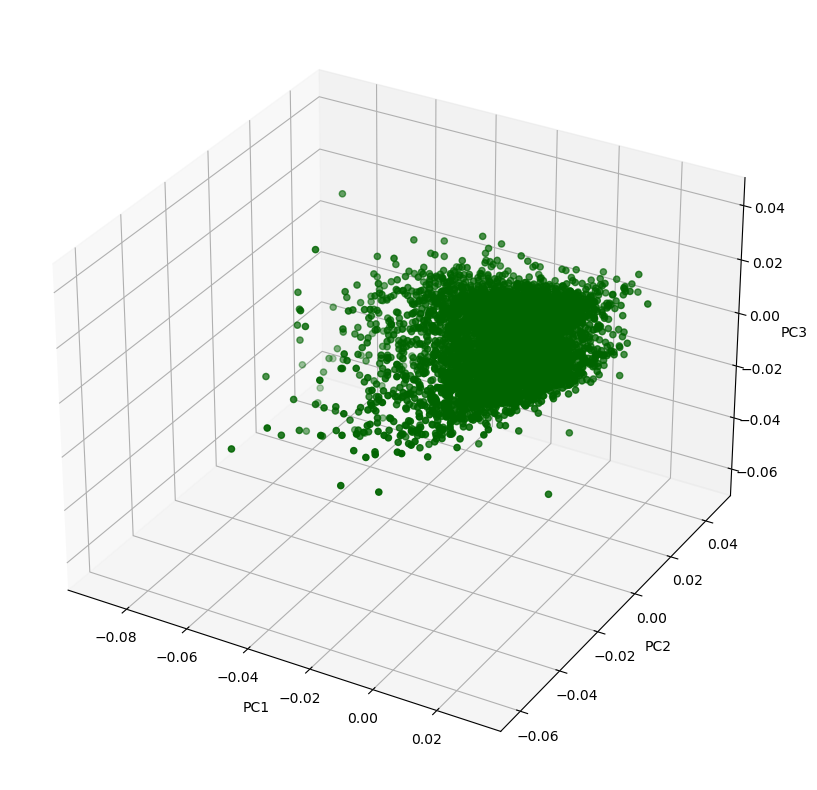

In [239]:
fig = plt.figure(figsize =(10,10))
ax = plt.axes(projection='3d')

ax.scatter(pca.components_[0,:], pca.components_[1,:], pca.components_[2,:], color = 'darkgreen')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### Clustering

In [240]:
from sklearn.cluster import KMeans, DBSCAN

# select components of interest
PCs = pca.components_[:6,:].T
PCs.shape

(5024, 6)

In [241]:
def silhouette(data, labels):
    """ Returns silhouette score of data [n_samples x n_features]"""
    return sklearn.metrics.silhouette_score(data, labels=labels)

def plot_silhouettes(x, silhouettes, param, clustering_type, n_clusters = None):
    """ Plot silhouette score """
    fig, ax = plt.subplots()
    ax.plot(x, silhouettes)
    if n_clusters is not None:
        for n, x_, y_ in zip(n_clusters, x, silhouettes):
            ax.text(x_, y_, str(n) + ' cl.', fontsize = 12)
    fig.suptitle(f'Silhouette score on clustering method: {clustering_type}')
    ax.set_xlabel(param)
    ax.set_ylabel('Silhouette score')
    plt.show()

In [242]:
N_list = np.arange(2,11,1)
kmeans_silhouettes = list()

for n in N_list:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(PCs)
    kmeans_silhouettes.append(silhouette(data, kmeans.labels_))

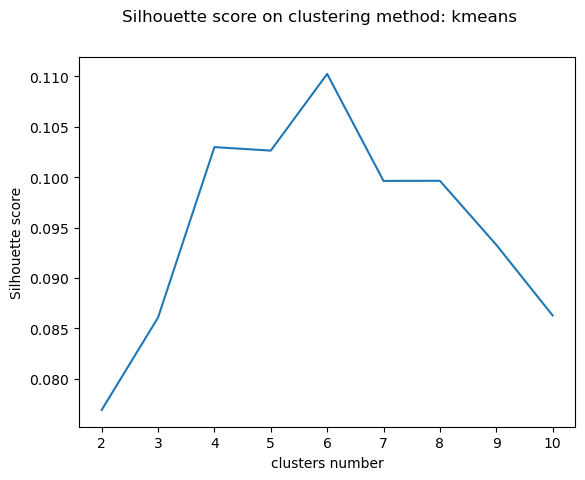

In [243]:
plot_silhouettes(N_list, kmeans_silhouettes, 'clusters number', 'kmeans')

In [244]:
eps_list = np.arange(0.01,0.02,0.001)
DBSCAN_silhouettes, n_clusters = list(), list()

for eps in eps_list:
    dbscan = DBSCAN(eps, min_samples = 3).fit(PCs)
    DBSCAN_silhouettes.append(silhouette(data, dbscan.labels_))
    # get number of clusters, taken from sklearn tutorial
    n_clusters.append(len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))

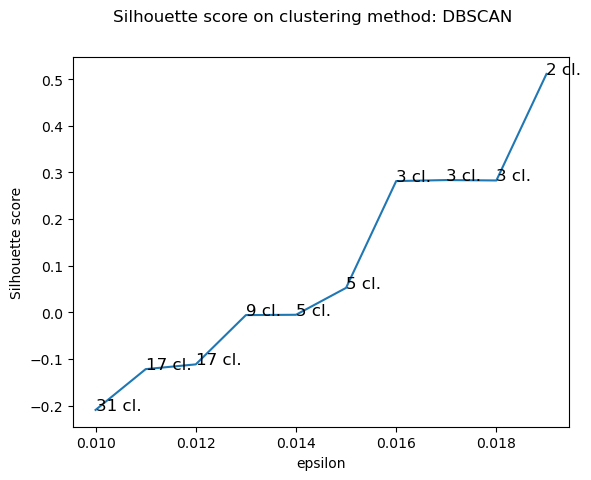

In [245]:
plot_silhouettes(eps_list, DBSCAN_silhouettes, 'epsilon', 'DBSCAN', n_clusters)

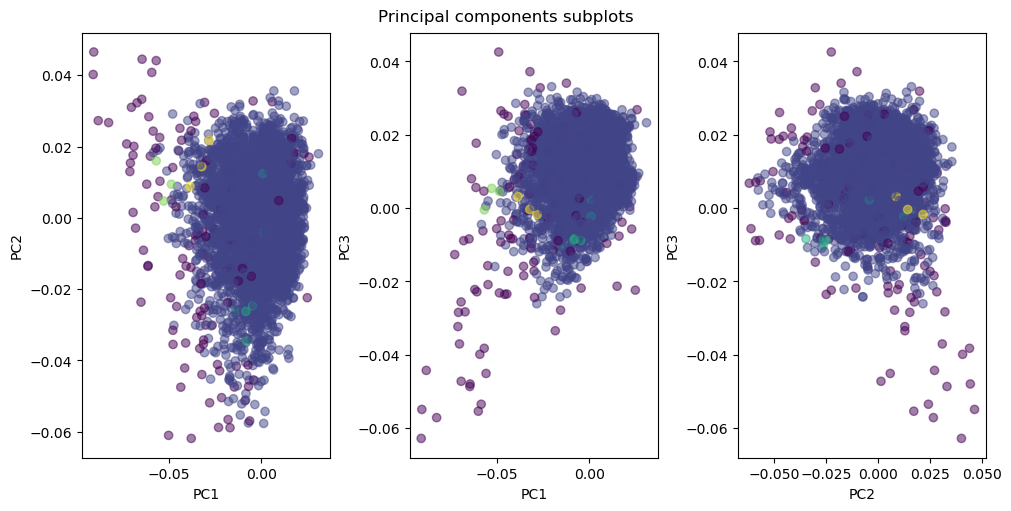

In [246]:
dbscan = DBSCAN(0.015, min_samples = 3).fit(PCs)
plot_components(PCs.T, color = dbscan.labels_, alpha=0.5)

On y voit pas grand chose oups

### PCA sur les features

We can be interested to which features contribute the most to the first PCA component  

In [247]:
pca_feat = decomposition.PCA(n_components=10)
pca_feat.fit(data)

first_comp = pca_feat.components_[0]
first_comps = pd.DataFrame(zip(first_comp, data.columns), columns=['weights', 'features'])
first_comps['abs_weights'] = first_comps['weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)

,weights,features,abs_weights
24,-0.693509,log_revenue,0.693509
25,-0.656660,log_budget,0.656660
0,-0.260166,averageRating,0.260166
1,-0.092918,Action,0.092918
3,-0.079149,Adventure,0.079149
13,0.039811,Horror,0.039811
9,0.033997,Drama,0.033997
6,0.029888,Comedy,0.029888
19,-0.024971,SciFi,0.024971
18,0.021176,Romance,0.021176


The more important features that contribute to the PCA are the log_revenue, the log_budget and the averageRating.

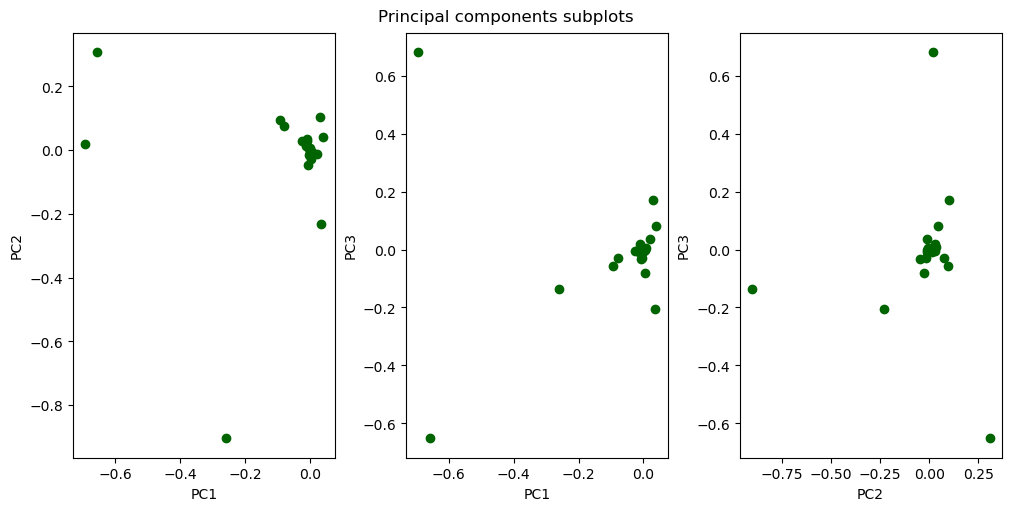

In [248]:
plot_components(pca_feat.components_)

We can see that the log_revenue, the log_budget and the averageRating are far way from the genres in the PC plots, the genres seem to cluster well 

### Separation of the data into 4 different clusters 

In [249]:
data.describe()

,averageRating,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
count,5.024000e+03,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,...,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5024.000000,5.024000e+03,5.024000e+03
mean,-8.333026e-17,0.278264,0.000398,0.175756,0.010151,0.062500,0.373408,0.203225,0.007763,0.518312,...,0.096736,0.000398,0.180135,0.085788,0.023885,0.173169,0.021099,0.008957,-5.241959e-16,-1.827841e-16
std,1.000100e+00,0.448189,0.019950,0.380651,0.100251,0.242086,0.483757,0.402438,0.087773,0.499714,...,0.295627,0.019950,0.384338,0.280079,0.152707,0.378431,0.143728,0.094226,1.000100e+00,1.000100e+00
min,-5.143134e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.574592e+00,-1.058616e+01
25%,-5.792482e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.624381e-01,-3.917195e-01
50%,8.631852e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.574003e-01,1.727205e-01
75%,6.568043e-01,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.932421e-01,6.102814e-01
max,2.748585e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.045316e+00,2.283010e+00


In [250]:
data_HR_LB = data[np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_HR_HB = data[np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] > data['log_budget'].quantile(0.75))]
data_LR_LB = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.25), data['log_budget'] < data['log_budget'].quantile(0.25))]
data_LR_HB = data[np.logical_and(data['averageRating'] < data['averageRating'].quantile(0.25), data['log_budget'] > data['log_budget'].quantile(0.75))]

print(data_HR_LB.shape)
print(data_HR_HB.shape)
print(data_LR_LB.shape)
print(data_LR_HB.shape)

(353, 26)
(295, 26)
(294, 26)
(279, 26)


We can interestingly see that there are more movies that have a high average rating and a low budget compare to the other categories. We have to do more analyses to conclude even if we took the same cutoff for all the categories.

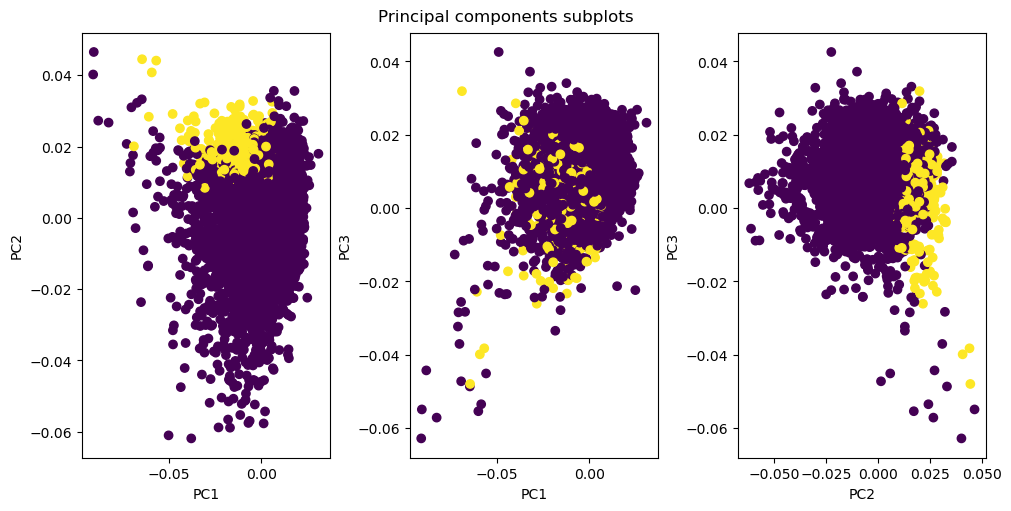

In [251]:
color = np.logical_and(data['averageRating'] > data['averageRating'].quantile(0.75), data['log_budget'] < data['log_budget'].quantile(0.25))
plot_components(pca.components_, color=color)

We can see that the high averageRating and low budget form clusters in the first 3 PCs 2D plots.

In [252]:
data_HR_LB_genres = data_HR_LB.drop(columns=['averageRating', 'log_budget', 'log_revenue'])
data_HR_HB_genres = data_HR_HB.drop(columns=['averageRating', 'log_budget', 'log_revenue'])
data_LR_HB_genres = data_HR_HB.drop(columns=['averageRating', 'log_budget', 'log_revenue'])
data_LR_LB_genres = data_HR_HB.drop(columns=['averageRating', 'log_budget', 'log_revenue'])

In [253]:
# ATTENTION : c'est de la merde a pouvoir display les graphique plotly --> 
# conda install -c plotly plotly=5.11.0
# conda install -c conda-forge jupyterlab-plotly-extension

import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'jupyterlab'
plotly.offline.init_notebook_mode(connected=True)

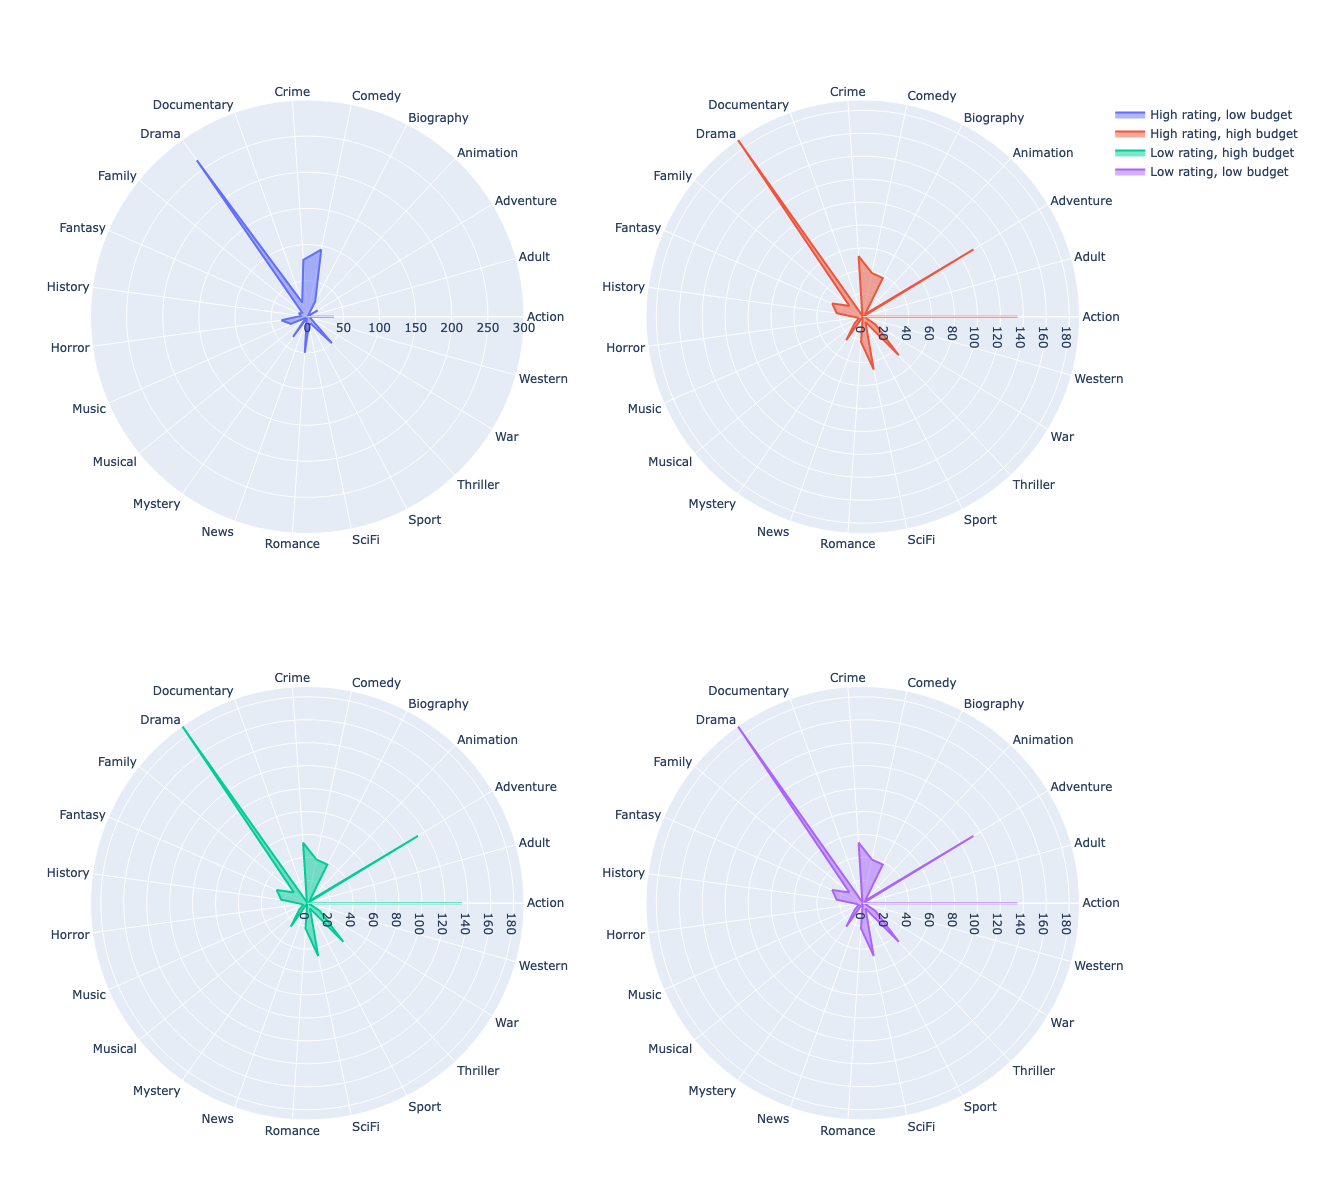

In [254]:
categories = data_HR_LB_genres.columns.values

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2)

fig.append_trace(go.Scatterpolar(r=data_HR_LB_genres.sum().values, theta=categories, fill='toself', name='High rating, low budget'), row=1, col=1)
fig.append_trace(go.Scatterpolar(r=data_HR_HB_genres.sum().values, theta=categories, fill='toself', name='High rating, high budget'), row=1, col=2)
fig.append_trace(go.Scatterpolar(r=data_LR_HB_genres.sum().values, theta=categories, fill='toself', name='Low rating, high budget'), row=2, col=1)
fig.append_trace(go.Scatterpolar(r=data_LR_LB_genres.sum().values, theta=categories, fill='toself', name='Low rating, low budget'), row=2, col=2)

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 300]
    )),
    width=1200,
    height=1200,
  showlegend=True
)

fig.show()

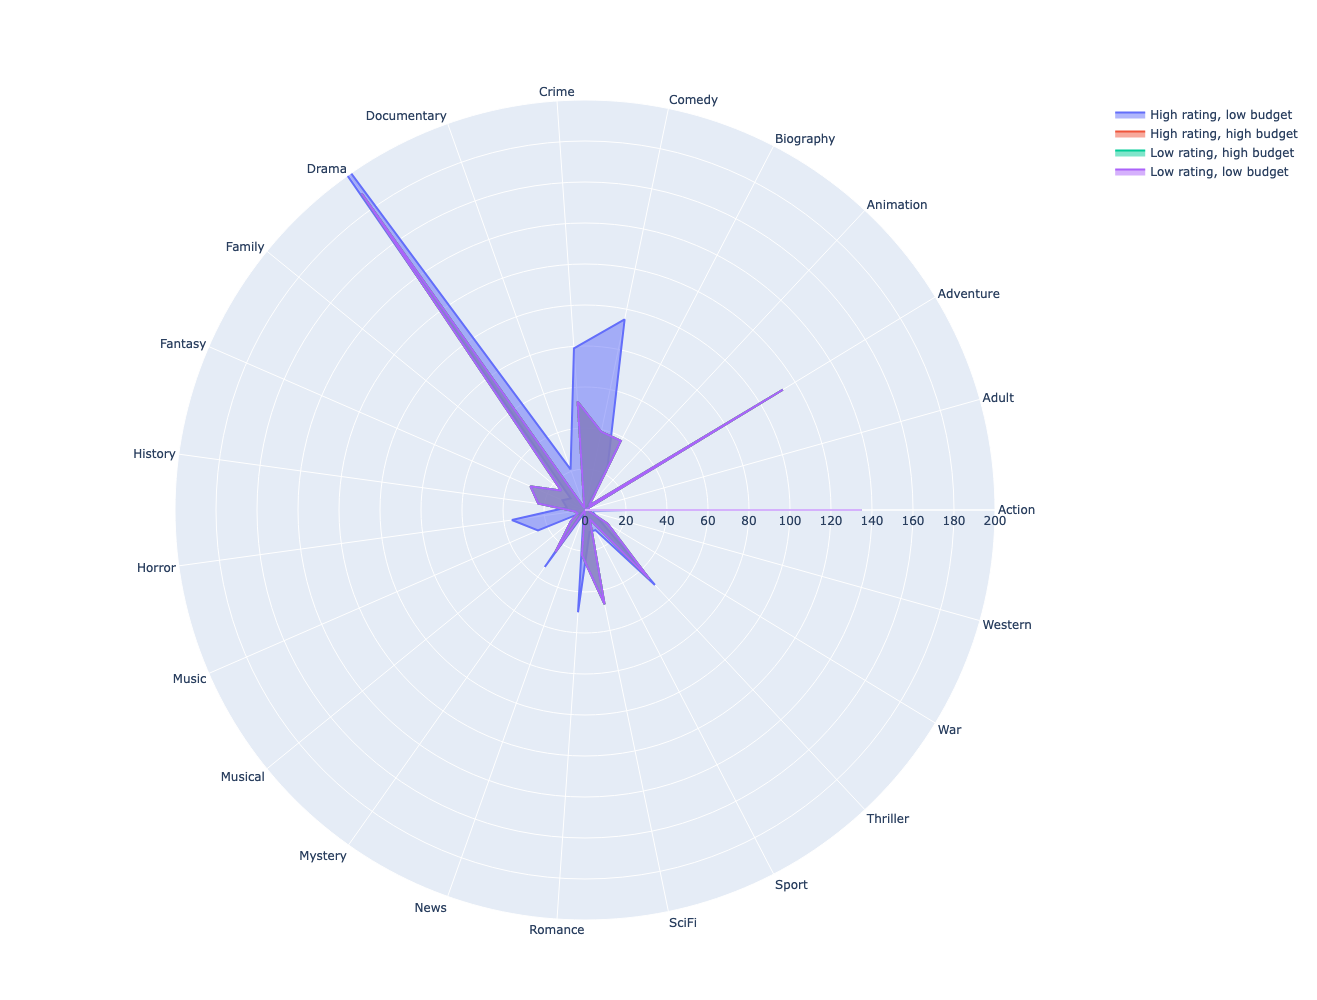

In [255]:
categories = data_HR_LB_genres.columns.values

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=data_HR_LB_genres.sum().values,
      theta=categories,
      fill='toself',
      name='High rating, low budget'
))
fig.add_trace(go.Scatterpolar(
      r=data_HR_HB_genres.sum().values,
      theta=categories,
      fill='toself',
      name='High rating, high budget'
))

fig.add_trace(go.Scatterpolar(
      r=data_LR_HB_genres.sum().values,
      theta=categories,
      fill='toself',
      name='Low rating, high budget'
))

fig.add_trace(go.Scatterpolar(
      r=data_LR_LB_genres.sum().values,
      theta=categories,
      fill='toself',
      name='Low rating, low budget'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 200]
    )),
    width=1000,
    height=1000,
  showlegend=True
)

fig.show()

### Matching 

matching with the two datasets : data_HR_LB and data_HR_HB

matching on :
- realease date
- revenue ?

--> see the effect on the movie genres 

J'ai essayé d'inclure le revenue dans le matching avec une fonction is close avec une tolérance mais il faut mettre une énorme tolérance pour avoir des matchs, donc je  ne pense pas que ca soit le top, j'ai quand meme laissé le code pour l'instant

In [256]:
# Add the date to the dataset to match
pd.options.mode.chained_assignment = None
data_HR_LB['Date'] = df_movie.loc[data_HR_LB.index]['Movie release date']
data_HR_HB['Date'] = df_movie.loc[data_HR_HB.index]['Movie release date']

In [257]:
#import math

# Not display the warnings, even if we used .loc the warnings are still there
pd.options.mode.chained_assignment = None

# Tolerance for the is close
#TOL = 1

# To not match more than 1 time the same movie
data_HR_LB['is_not_matched'] = True
data_HR_HB['is_not_matched'] = True
ind_LB = []
ind_HB = []

# Iteration on the two dataframes to find matches
for LB_id, LB_row in data_HR_LB.iterrows():
    for HB_id, HB_row in data_HR_HB.iterrows():

        # To match the athletes must have the same year of birth, the same sex, the same occupation
        # and we have to pay attention to not match an athelte more than 1 time
        if (LB_row['Date'] == HB_row['Date'])\
            and data_HR_LB.loc[LB_id, 'is_not_matched']\
            and data_HR_HB.loc[HB_id, 'is_not_matched'] :
            #and math.isclose(LB_row['log_budget'], HB_row['log_budget'], abs_tol = TOL) 
            
                # Set is not matched to False to not match an athelte more than 1 time
                data_HR_LB.loc[LB_id,'is_not_matched'] = False
                data_HR_HB.loc[HB_id, 'is_not_matched'] = False
                # Record the index of the matches
                ind_LB.append(LB_id)
                ind_HB.append(HB_id)

# Concatenation of the two list of indexes
ind = ind_LB + ind_HB

In [258]:
match_data = data.loc[ind]
print(match_data.shape)
match_data_HR_LB = data_HR_LB.loc[ind_LB]
print(match_data_HR_LB.shape)
match_data_HR_HB = data_HR_HB.loc[ind_HB]
print(match_data_HR_HB.shape)

(478, 26)
(239, 28)
(239, 28)


## Scatter plot

In [28]:
mod = smf.ols(formula="log_revenue ~ log_budget ", data=data)
res = mod.fit()

In [29]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     1916.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:17:12   Log-Likelihood:                -9825.9
No. Observations:                5018   AIC:                         1.966e+04
Df Residuals:                    5016   BIC:                         1.967e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1076      0.260     23.472      0.000       5.598       6.618
log_budget     0.6687      0.015     43.770      0.000       0.639       0.699
==============================================================================
Omnibus:                      948.786   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5696.397
Skew:                          -0.767   Prob(JB):                         0.00
Kurtosis:                       7.989   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
coef = res.params.values

C:\Users\lisap\anaconda3\envs\IPLAB\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


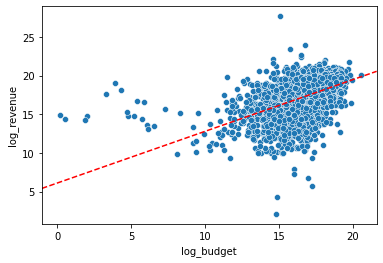

In [31]:
fig = sns.scatterplot(data.log_budget,data.log_revenue)
fig.axline((0,coef[0]), slope=coef[1], color='red', label='Linear fit',linestyle='dashed')
plt.show()

C:\Users\lisap\anaconda3\envs\IPLAB\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


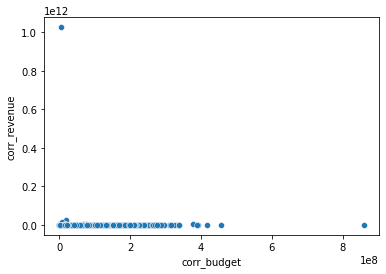

In [32]:
sns.scatterplot(data.corr_budget, data.corr_revenue)
plt.show()

Let's select the movies with log budget lower than 7

In [33]:
low_budget = data.loc[data.log_budget <= 7]

In [34]:
low_budget

,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
13623,7.4,219.371698,1.812451e+07,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,16.712776,5.390768
22132,4.5,177.076236,2.488442e+06,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,14.727168,5.176580
27788,7.8,351.830477,1.556932e+07,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,16.560813,5.863149
28742,6.5,124.876181,2.467007e+06,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,14.718516,4.827323
30113,6.9,446.949814,8.167250e+05,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13.613058,6.102446
41902,7.1,321.112963,1.711641e+06,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,14.352963,5.771793
50036,6.1,50.209385,1.832655e+08,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,19.026446,3.916202
57920,5.6,73.123899,7.974554e+07,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,18.194351,4.292155
64790,7.0,1.662306,1.678628e+06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14.333488,0.508206
66740,6.0,7.455985,2.684583e+06,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,14.803036,2.009017


In [35]:
df = low_budget.copy()
df = df.drop(columns = ['averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

In [36]:
df

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Music,Musical,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western
13623,0,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
22132,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
27788,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
28742,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30113,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
41902,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
50036,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
57920,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
64790,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
66740,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


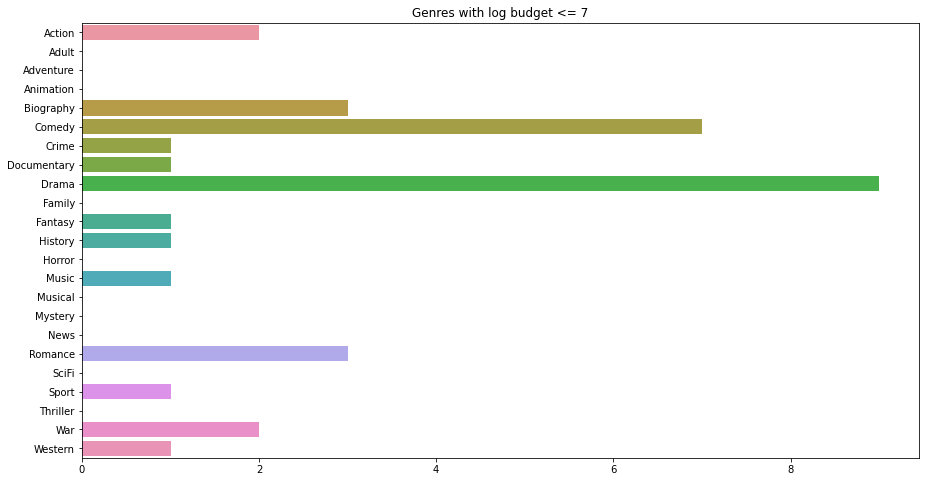

In [37]:
genres = df.columns
tot = []
for gen in genres:
    tot.append(sum(df[gen]))
plt.figure(figsize=(15,8))
ax = sns.barplot(x=tot, y=genres).set(title='Genres with log budget <= 7')
plt.show()

In [38]:
all_tot = []
for gen in genres:
    all_tot.append(sum(data[gen]))

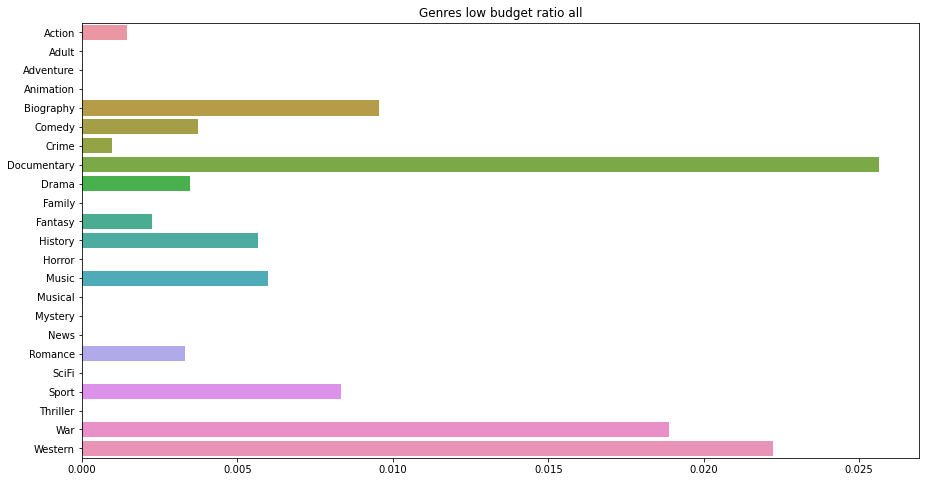

In [39]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres low budget ratio all')
plt.show()

In [58]:
high_revenue = data.loc[data.log_revenue >= (np.log(10) + data.log_budget)]
#high_revenue = data.copy()

In [59]:
df = high_revenue.copy()
df = df.drop(columns = ['averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

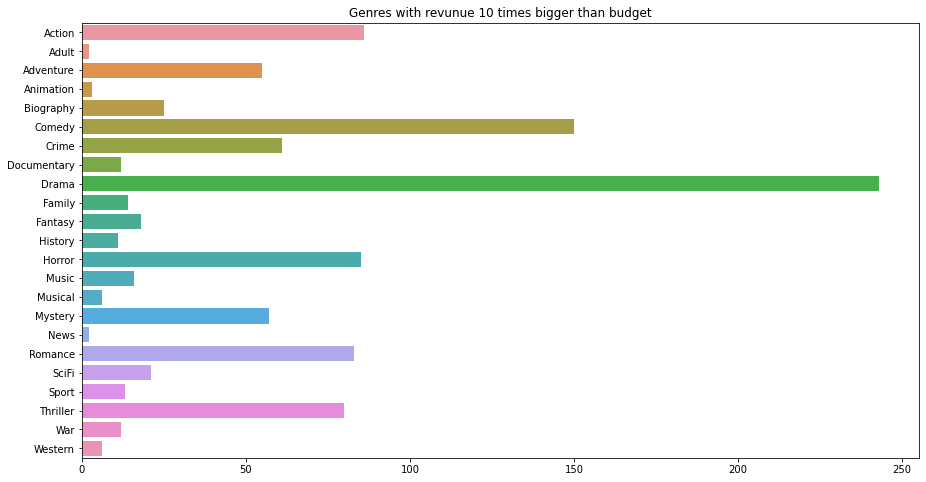

In [61]:
genres = df.columns
tot = []
for gen in genres:
    tot.append(sum(df[gen]))
plt.figure(figsize=(15,8))
ax = sns.barplot(x=tot, y=genres).set(title='Genres with revunue 10 times bigger than budget')
plt.show()

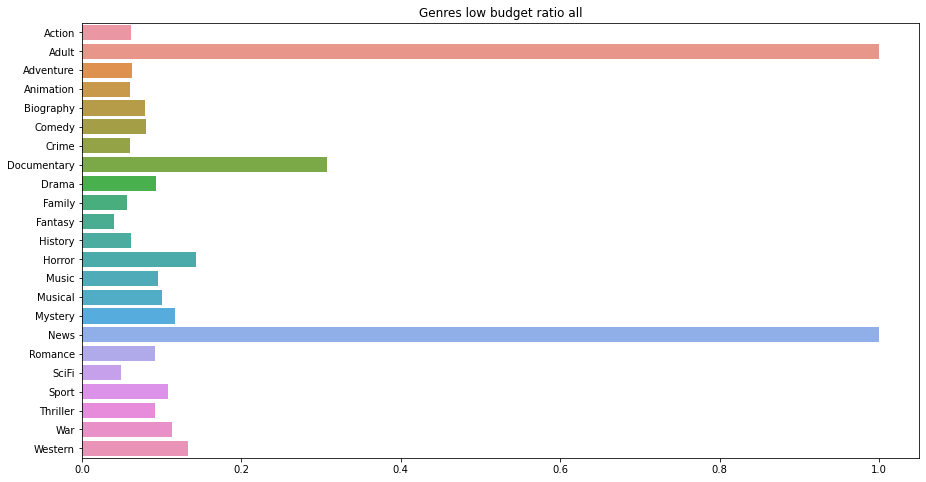

In [62]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres low budget ratio all')
plt.show()

In [70]:
data.loc[data.Adult == 1]

,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
10786,5.9,3.887968e+05,3.239973e+08,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,19.596246,12.870812
51118,6.2,1.904605e+06,4.285361e+08,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,19.875886,14.459785


In [73]:
df_movie.iloc[51118]

Freebase movie ID                                                   /m/06wbq4
IMDB_id                                                             tt0074113
Movie box office revenue                                           90000000.0
Movie genres names                             ['Adult', 'Comedy', 'Fantasy']
Movie name                     Alice in Wonderland: An X-Rated Musical Comedy
Movie release date                                                     1976.0
averageRating                                                             6.2
budget                                                               400000.0
numVotes                                                               3025.0
prod_country                                                              NaN
inflation coeff                                                      4.761513
inflation corrected revenue                                  428536139.991214
inflation corrected budget                                     1